In [27]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [28]:
df = pd.read_csv("final_airbnb_dataset.csv")

df.columns.tolist()



['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'host_id',
 'host_url',
 'host_since',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'calendar_last_scraped',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'rev

In [29]:
features = [
    'distance_score', 'price_score', 'number_of_reviews',
    'availability_365', 'review_scores_rating',
]

df_model = df.dropna(subset=features + ['booked'])

X = df_model[features]
y = df_model['booked'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

In [31]:
class AirbnbModel(nn.Module):
    def __init__(self, input_dim):
        super(AirbnbModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Initialize model, loss, optimizer
model = AirbnbModel(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [43]:
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Predict probabilities on the full dataset
# Make predictions
with torch.no_grad():
    all_features_tensor = torch.tensor(df_model[features].values, dtype=torch.float32)
    probs = model(all_features_tensor).numpy().flatten()

# Ensure the shapes match
assert len(probs) == len(df_model), "Shape mismatch: probs doesn't align with df_model"

# Assign predictions
df_model = df_model.copy()
df_model['predicted_proba'] = probs

# Confirm it worked
print(df_model.columns)
print(df_model[['predicted_proba']].head())


Epoch 10, Loss: 0.1579
Epoch 20, Loss: 0.1328
Epoch 30, Loss: 0.1284
Epoch 40, Loss: 0.1265
Epoch 50, Loss: 0.1256
Epoch 60, Loss: 0.1247
Epoch 70, Loss: 0.1239
Epoch 80, Loss: 0.1234
Epoch 90, Loss: 0.1228
Epoch 100, Loss: 0.1223
Epoch 110, Loss: 0.1218
Epoch 120, Loss: 0.1213
Epoch 130, Loss: 0.1208
Epoch 140, Loss: 0.1203
Epoch 150, Loss: 0.1198
Epoch 160, Loss: 0.1193
Epoch 170, Loss: 0.1188
Epoch 180, Loss: 0.1183
Epoch 190, Loss: 0.1209
Epoch 200, Loss: 0.1180
Epoch 210, Loss: 0.1210
Epoch 220, Loss: 0.1169
Epoch 230, Loss: 0.1207
Epoch 240, Loss: 0.1165
Epoch 250, Loss: 0.1163
Epoch 260, Loss: 0.1269
Epoch 270, Loss: 0.1263
Epoch 280, Loss: 0.1147
Epoch 290, Loss: 0.1147
Epoch 300, Loss: 0.1506
Epoch 310, Loss: 0.1153
Epoch 320, Loss: 0.1148
Epoch 330, Loss: 0.1143
Epoch 340, Loss: 0.1123
Epoch 350, Loss: 0.1155
Epoch 360, Loss: 0.1120
Epoch 370, Loss: 0.1143
Epoch 380, Loss: 0.1150
Epoch 390, Loss: 0.1101
Epoch 400, Loss: 0.1225
Epoch 410, Loss: 0.1550
Epoch 420, Loss: 0.1702
E

In [33]:
print(df_model.columns.tolist())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'host_id', 'host_url', 'host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'rev

In [44]:
top_10 = df_model.sort_values(by='predicted_proba', ascending=False).head(10)
top_10_links = top_10[['id', 'listing_url', 'predicted_proba']]

print("\n🔗 Top 10 Recommended Airbnbs with URLs:\n")
for _, row in top_10_links.iterrows():
    print(f"ID: {row['id']} | Score: {row['predicted_proba']:.2f} | URL: {row['listing_url']}")



🔗 Top 10 Recommended Airbnbs with URLs:

ID: 49713396 | Score: 1.00 | URL: https://www.airbnb.com/rooms/49713396
ID: 53346269 | Score: 1.00 | URL: https://www.airbnb.com/rooms/53346269
ID: 4349358 | Score: 1.00 | URL: https://www.airbnb.com/rooms/4349358
ID: 39627045 | Score: 1.00 | URL: https://www.airbnb.com/rooms/39627045
ID: 4951402 | Score: 1.00 | URL: https://www.airbnb.com/rooms/4951402
ID: 8663101 | Score: 1.00 | URL: https://www.airbnb.com/rooms/8663101
ID: 10887847 | Score: 1.00 | URL: https://www.airbnb.com/rooms/10887847
ID: 660036 | Score: 1.00 | URL: https://www.airbnb.com/rooms/660036
ID: 13259442 | Score: 1.00 | URL: https://www.airbnb.com/rooms/13259442
ID: 46543084 | Score: 1.00 | URL: https://www.airbnb.com/rooms/46543084


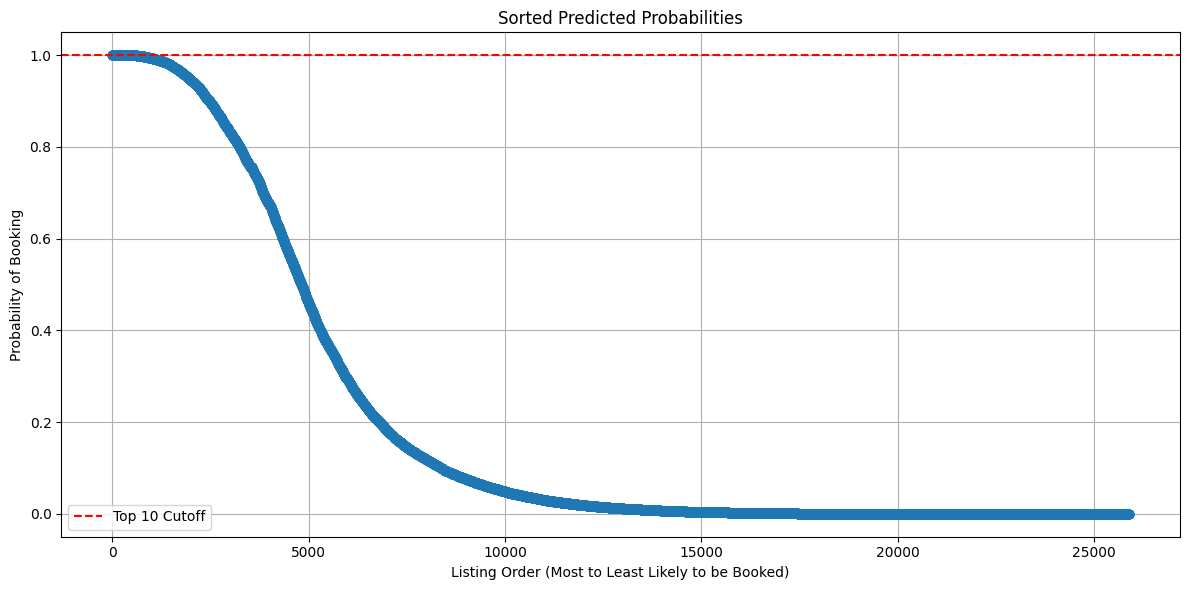

In [45]:
plt.figure(figsize=(12, 6))
sorted_probs = df_model['predicted_proba'].sort_values(ascending=False).reset_index(drop=True)
plt.plot(sorted_probs, marker='o', linestyle='', alpha=0.6)
plt.axhline(top_10['predicted_proba'].min(), color='red', linestyle='--', label="Top 10 Cutoff")
plt.title('Sorted Predicted Probabilities')
plt.xlabel('Listing Order (Most to Least Likely to be Booked)')
plt.ylabel('Probability of Booking')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
